# Logistic and linear regression with deterministic and stochastic first order methods

    Lab 2 : Optimisation - DataScience Master
    Authors : Alexandre Gramfort, Hicham Janati
   
The aim of this lab is to implement and compare various batch and stochastic algorithms for linear and logistic regression with ridge penalization.

The following methods are compared in this notebook.

**Batch (deterministic) methods**

- gradient descent (GD)
- accelerated gradient descent (AGD)

**Stochastic algorithms**

- stochastic gradient descent (SGD)
- stochastic averaged gradient (SAG)
- stochastic variance reduced gradient (SVRG)

Note that we consider as use-cases logistic and linear regression with ridge penalization only, although most of the algorithms below can be used with many other models, and other types of penalization, even non-smooth ones, such as the $\ell_1$ penalization.


## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work using the **moodle platform**, please
  check the deadline on moodle.
- This means that **each student in the pair sends the same file**
- The **name of the file must be** constructed as in the next cell

### How to construct the name of your file

In [ ]:
# Change here using YOUR first and last names
fn1 = "ralph"
ln1 = "mouawad"
fn2 = "charles"
ln2 = "karrer"

filename = "_".join(map(lambda s: s.strip().lower(),
                        ["lab2", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab2_mouawad_ralph_and_karrer_charles.ipynb


# Gentle reminder: no evaluation if you don't respect this EXACTLY

### Table of content

[1. Loss functions, gradients and step-sizes](#loss)<br>
[2. Generate a dataset](#data)<br>
[3. Deterministic methods](#batch)<br>
[4. Stochastic methods](#stoc)<br>
[5. Numerical comparison](#comp)<br>
[6. Conclusion](#conc)<br>

In [1]:
%matplotlib inline

In [2]:
from time import time

import numba
import numpy as np
from scipy.linalg import norm
import matplotlib.pyplot as plt
from numba import njit

In [3]:
# choose a large font size by default and use tex for math
usetex = False  # change this to True if you have a working LaTeX install

fontsize = 16
params = {
    "axes.labelsize": fontsize + 2,
    "font.size": fontsize + 2,
    "legend.fontsize": fontsize + 2,
    "xtick.labelsize": fontsize,
    "ytick.labelsize": fontsize,
    "text.usetex": usetex,
}
plt.rcParams.update(params)

<a id='numba'></a>
## 0. Make sure Numba is correctly installed
Instructions available at: http://numba.pydata.org/numba-doc/latest/user/installing.html

In [4]:
print(numba.__version__) # Your version of Numba

0.60.0


In [5]:
@njit
def go_fast(a): # Function is compiled to machine code when called the first time
    trace = 0.0
    # assuming square input matrix
    for i in range(a.shape[0]):   # Numba likes loops
        trace += np.tanh(a[i, i]) # Numba likes NumPy functions
    return a + trace              # Numba likes NumPy broadcasting

x = np.arange(100).reshape(10, 10)
x = x.astype(float)
go_fast(x) # Running a first time the function to compile it

array([[  9.,  10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.],
       [ 19.,  20.,  21.,  22.,  23.,  24.,  25.,  26.,  27.,  28.],
       [ 29.,  30.,  31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.],
       [ 39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,  48.],
       [ 49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.],
       [ 59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.],
       [ 69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,  78.],
       [ 79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.],
       [ 89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.],
       [ 99., 100., 101., 102., 103., 104., 105., 106., 107., 108.]])

In [6]:
np.tanh(0)+ np.tanh(10) + np.tanh(20)

np.float64(1.9999999958776926)

Iteration time of the Numba-compiled function.

In [7]:
%timeit go_fast(x)

2.31 µs ± 754 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


Numba-compiled function have a special `.py_func` attribute which is the original uncompiled Python function.  Iteration time of the uncompiled function should be greater.

In [8]:
%timeit go_fast.py_func(x)

30.6 µs ± 7.63 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


<a id='loss'></a>
## 1. Loss functions, gradients and step-sizes


We want to minimize
$$
\frac 1n \sum_{i=1}^n \ell(a_i^\top x, b_i) + \frac \lambda 2 \|x\|_2^2
$$
where
- $\ell(z, b) = \frac 12 (b - z)^2$ (least-squares regression)
- $\ell(z, b) = \log(1 + \exp(-bz))$ (logistic regression).

We write it as a minimization problem of the form
$$
\frac 1n \sum_{i=1}^n f_i(x)
$$
where
$$
f_i(x) = \ell(a_i^\top x, b_i) + \frac \lambda 2 \|x\|_2^2.
$$

For each cases, the gradients are
$$
\nabla f_i(x) = (a_i^\top x - b_i) a_i + \lambda x
$$
and
$$
\nabla f_i(x) = - \frac{b_i}{1 + \exp(b_i a_i^\top x)} a_i + \lambda x.
$$

Denote by $L$ (resp. $L_i$) the Lipschitz constant of $f$ (resp. $f_i$) and $\mathbf A^\top = [a_1, \ldots, a_n].$
One can easily see (using $\|\cdot\|_{2}$ for the matrix spectrale norm) that for least-squares regression
$$
L = \frac{ \|\mathbf A^\top \mathbf A \|_{2}}{n} + \lambda \quad \text{ and } L_i = \| a_i \|_2^2 + \lambda
$$
while for logistic regression it is
$$
L = \frac{ \|\mathbf A^\top \mathbf A \|_{2}}{4 n} + \lambda \quad \text{ and } L_i = \frac 14 \| a_i \|_2^2 + \lambda.
$$
For full-gradient methods, the theoretical step-size is $1 / L$, while for SAG and SVRG (see below) it can be taken as
$1 / (\max_{i=1,\ldots,n} L_i)$

We now introduce functions that will be used for the solvers.


In [9]:
@njit
def grad_i_linreg(i, x, A, b, lbda):
    """Gradient with respect to a sample"""
    a_i = A[i]
    return (a_i.dot(x) - b[i]) * a_i + lbda * x


@njit
def grad_linreg(x, A, b, lbda):
    """Full gradient"""
    g = np.zeros_like(x)
    for i in range(n):
        g += grad_i_linreg(i, x, A, b, lbda)
    return g / n


def loss_linreg(x, A, b, lbda):
    return norm(A.dot(x) - b) ** 2 / (2. * n) + lbda * norm(x) ** 2 / 2.


def lipschitz_linreg(A, b, lbda):
    return norm(A, ord=2) ** 2 / n + lbda

In [10]:
@njit
def grad_i_logreg(i, x, A, b, lbda):
    """Gradient with respect to a sample"""
    a_i = A[i]
    b_i = b[i]
    return - a_i * b_i / (1. + np.exp(b_i * np.dot(a_i, x))) + lbda * x


@njit
def grad_logreg(x, A, b, lbda):
    """Full gradient"""
    g = np.zeros_like(x)
    for i in range(n):
        g += grad_i_logreg(i, x, A, b, lbda)
    return g / n


def loss_logreg(x, A, b, lbda):
    bAx = b * np.dot(A, x)
    return np.mean(np.log(1. + np.exp(- bAx))) + lbda * norm(x) ** 2 / 2.


def lipschitz_logreg(A, b, lbda):
    return norm(A, ord=2) ** 2 / (4. * n) + lbda

<a id='data'></a>
## 2. Generate a dataset

We generate datasets for the least-squares and the logistic cases. First we define a function for the least-squares case.

In [11]:
from numpy.random import multivariate_normal, randn
from scipy.linalg import toeplitz


def simu_linreg(x, n, std=1., corr=0.5):
    """Simulation for the least-squares problem.

    Parameters
    ----------
    x : ndarray, shape (d,)
        The coefficients of the model
    n : int
        Sample size
    std : float, default=1.
        Standard-deviation of the noise
    corr : float, default=0.5
        Correlation of the features matrix

    Returns
    -------
    A : ndarray, shape (n, d)
        The design matrix.
    b : ndarray, shape (n,)
        The targets.
    """
    d = x.shape[0]
    cov = toeplitz(corr ** np.arange(0, d))
    A = multivariate_normal(np.zeros(d), cov, size=n)
    noise = std * randn(n)
    b = A.dot(x) + noise
    return A, b

In [12]:
def simu_logreg(x, n, std=1., corr=0.5):
    """Simulation for the logistic regression problem.

    Parameters
    ----------
    x : ndarray, shape (d,)
        The coefficients of the model
    n : int
        Sample size
    std : float, default=1.
        Standard-deviation of the noise
    corr : float, default=0.5
        Correlation of the features matrix

    Returns
    -------
    A : ndarray, shape (n, d)
        The design matrix.
    b : ndarray, shape (n,)
        The targets.
    """
    A, b = simu_linreg(x, n, std=1., corr=corr)
    return A, np.sign(b)

In [13]:
d = 50
n = 10000
idx = np.arange(d)

# Ground truth coefficients of the model
x_model_truth = (-1)**idx * np.exp(-idx / 10.)

_A, _b = simu_linreg(x_model_truth, n, std=1., corr=0.1)
#_A, _b = simu_logreg(x_model_truth, n, std=1., corr=0.7)

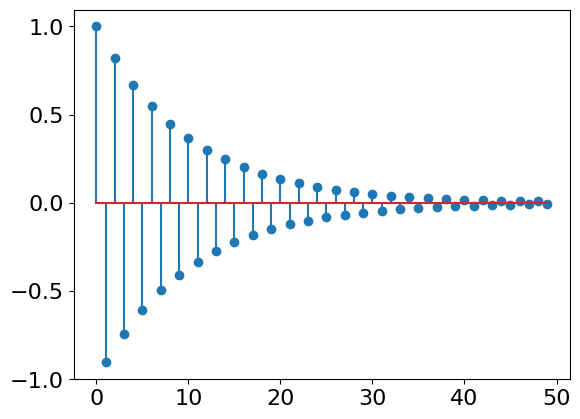

In [14]:
plt.stem(x_model_truth);

### Numerically check loss and gradient

In [15]:
from scipy.optimize import check_grad

lbda = 1. / n ** (0.5)

A, b = simu_linreg(x_model_truth, n, std=1., corr=0.1)
# Check that the gradient and the loss numerically match
check_grad(loss_linreg, grad_linreg, np.random.randn(d), A, b, lbda)

np.float64(1.6755289112274053e-06)

In [16]:
lbda = 1. / n ** (0.5)

A, b = simu_logreg(x_model_truth, n, std=1., corr=0.1)
# Check that the gradient and the loss numerically match
check_grad(loss_logreg, grad_logreg, np.random.randn(d), A, b, lbda)

np.float64(1.4398209316235747e-07)

### Choice of the model

In [121]:
# A, b = simu_linreg(x_model_truth, n, std=1., corr=0.9)
# A, b = simu_linreg(x_model_truth, n, std=1., corr=0.1)
A, b = simu_linreg(x_model_truth, n, std=1., corr=0.4)


loss = loss_linreg
grad = grad_linreg
grad_i = grad_i_linreg
lipschitz_constant = lipschitz_linreg
lbda = 1. / n ** (0.5)
# low lbda  to test them comment and uncomment the lambdas
# lbda = 1. / n
# high lambda
# lbda = 1.

### Compute the theoretical step-size for gradient descent

In [122]:
step = 1. / lipschitz_constant(A, b, lbda)

print("step = %s" % step)

step = 0.42255406481605906


### Get a very precise minimum to compute distances to minimum

Here we use L-BFGS that you have not seen yet. Just take the estimated `x_min` and move on.
You will see L-BFGS later in the course.

In [123]:
from scipy.optimize import fmin_l_bfgs_b

x_init = np.zeros(d)
x_min, f_min, _ = fmin_l_bfgs_b(loss, x_init, grad,
                                args=(A, b, lbda), pgtol=1e-30, factr=1e-30)


print(f_min)
print(norm(grad_linreg(x_min, A, b, lbda)))

0.5262565480847607
5.9647049370421895e-09


<a id='batch'></a>

## 3. Deterministic/Batch methods (GD, AGD)

### Define a class to monitor iterations

In [124]:
class monitor:
    def __init__(self, algo, loss, x_min, args=()):
        self.x_min = x_min
        self.algo = algo
        self.loss = loss
        self.args = args
        self.f_min = loss(x_min, *args)

    def run(self, *algo_args, **algo_kwargs):
        t0 = time()
        _, x_list = self.algo(*algo_args, **algo_kwargs)
        self.total_time = time() - t0
        self.x_list = x_list
        self.err = [norm(x - self.x_min) for x in x_list]
        self.obj = [self.loss(x, *self.args) - self.f_min for x in x_list]

In [125]:
# Number of iterations
n_iter = 200

### Gradient descent (GD)

We recall that an iteration of batch gradient writes

$$
x_{k+1} \gets x_k - \eta \nabla f(x_k)
$$

where $\eta$ is the step-size (that can be chosen in theory as $\eta = 1 / L$, with $L$ the Lipshitz constant of $\nabla f$, see above)

*QUESTION*:
- Fill in the iteration of the GD solver in the cell below

In [126]:
@njit
def gd(x_init, grad, n_iter=100, step=1., store_every=1, args=()):
    """Gradient descent algorithm."""
    x = x_init.copy()
    x_list = []
    for i in range(n_iter):
        ### TODO
        x = x - step*grad(x,A,b, lbda)
        if i % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [127]:
step = 1. / lipschitz_linreg(A, b, lbda)
x_init = np.zeros(d)
monitor_gd = monitor(gd, loss, x_min, (A, b ,lbda))
monitor_gd.run(x_init, grad, n_iter, step, args=(A, b, lbda))

### Accelerated Gradient Descent (AGD)

We recall that an iteration of AGD (see FISTA) writes:

$$
\begin{align*}
x_{k+1} &\gets y_k - \eta \nabla f(y_k) \\
t_{k+1} &\gets \frac{1 + \sqrt{1 + 4 t_k^2}}{2} \\
y_{k+1} &\gets x_{k+1} + \frac{t_k-1}{t_{k+1}} (x_{k+1} - x_k)
\end{align*}
$$

where $\eta$ is the step-size (that can be chosen in theory as $\eta = 1 / L$, with $L$ the Lipschitz constant of $\nabla f$, see above)

*QUESTION*:
- Fill in the iteration of the AGD solver in the cell below

In [128]:
@njit
def agd(x_init, grad, n_iter=100, step=1., args=(), store_every=1):
    """Accelerated Gradient Descent algorithm."""
    x = x_init.copy()
    y = x_init.copy()
    t = 1.
    x_list = []
    for i in range(n_iter):
        if i % store_every == 0:
            x_list.append(x.copy())
        ### TODO
        x = y - step*grad(y, A, b, lbda)
        t_new = (1 + np.sqrt(1 + 4 * t ** 2)) / 2

        y = x + (t - 1) / t_new * (x - x_list[-1])
        t = t_new
    return x, x_list

In [129]:
step = 1. / lipschitz_linreg(A, b, lbda)
x_init = np.zeros(d)
monitor_agd = monitor(agd, loss, x_min, (A, b ,lbda))
monitor_agd.run(x_init, grad, n_iter, step, args=(A, b, lbda))

### A first numerical comparison of deterministic solvers

First, define some plotting functions.

In [49]:
def plot_epochs(monitors, solvers):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    for monit in monitors:
        plt.semilogy(monit.obj, lw=2)
        plt.title("Loss")
        plt.xlabel("Epoch")
        plt.ylabel("objective")

    plt.legend(solvers)

    plt.subplot(1, 2, 2)

    for monit in monitors:
        plt.semilogy(monit.err, lw=2)
        plt.title("Distance to optimum")
        plt.xlabel("Epoch")
        plt.ylabel("$\|x_k - x^*\|_2$")

    plt.legend(solvers)


def plot_time(monitors, solvers, xscale='linear', yscale='log'):
    for monit in monitors:
        objs = monit.obj
        plt.semilogy(np.linspace(0, monit.total_time, len(objs)), objs, lw=2)
        plt.title("Loss")
        plt.xlabel("Timing")
        plt.ylabel("$f(x_k) - f(x^*)$")
        plt.yscale(yscale)
        plt.xscale(xscale)

    plt.legend(solvers)

<>:18: SyntaxWarning: invalid escape sequence '\|'
<>:18: SyntaxWarning: invalid escape sequence '\|'
/tmp/ipython-input-307804148.py:18: SyntaxWarning: invalid escape sequence '\|'
  plt.ylabel("$\|x_k - x^*\|_2$")


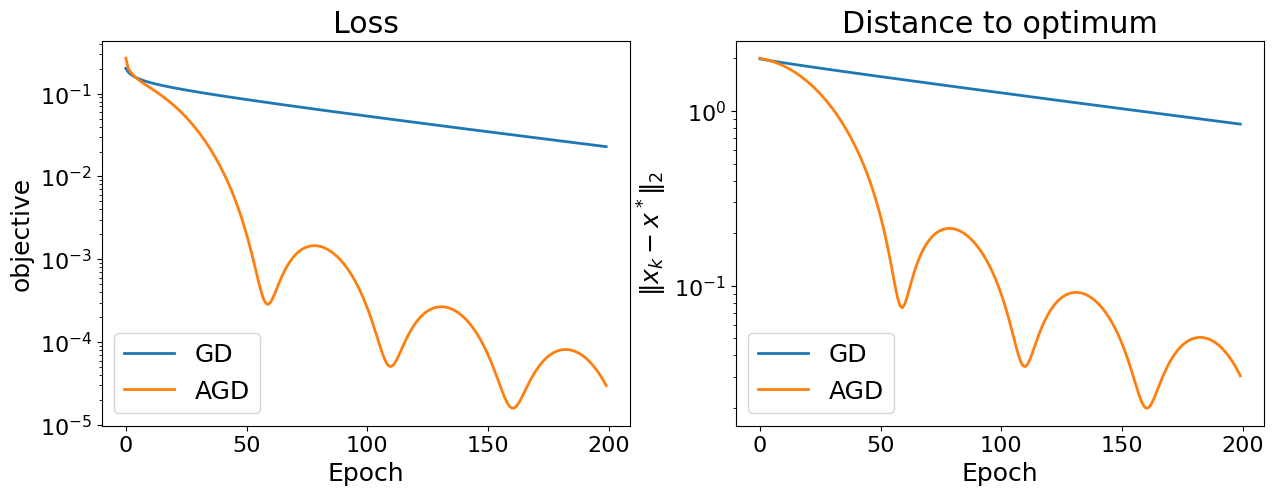

In [50]:
monitors = [monitor_gd, monitor_agd]

solvers = ["GD", "AGD"]

plot_epochs(monitors, solvers)

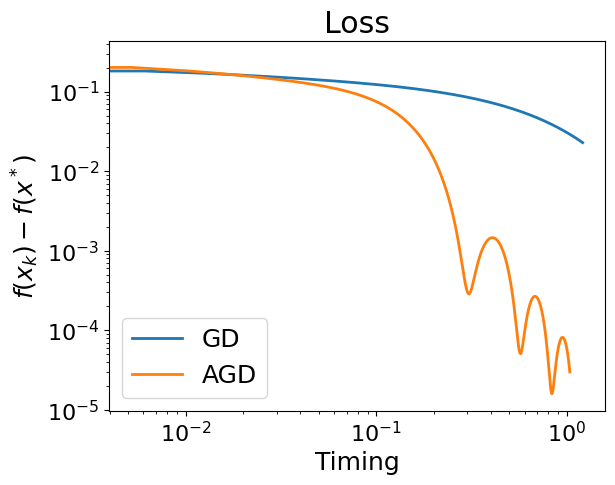

In [51]:
plot_time(monitors, solvers, xscale='log')

### First conclusions

*QUESTIONS*:

- Give some first conclusions about the batch solver studied here
- What do you observe about AGD? is it suprising ?

Answers:
- Both solvers decrease the objective function as well as the distance to optimality. However, the behavior and performance of both methods are not the same:
1) Gradient Descent's loss and distance to optimality decrease with time/ epochs in a smooth way and without oscillations. However, we are very far from optimality after 200 iterations: objective loss and distance to optimum are still very high.
2) Accelerated Gradient Descent's loss and distance to optimality decrease with time/ epochs but the solver suffers from an oscillatory behavior, which isn't surprising because this method looks where it is going before applying the gradient step. It uses some kind of momentum. However, after 200 iterations, we can see that AGD reached a much better point than standard GD since we have a much smaller loss and distance to optimum.


- We observe with AGD an oscillatory behavior, which is caused by the fact that it uses the past observations. It isn't surprising. This is mainly caused when we're approaching from the optimal point and see a change of sign somewhere, causing some overshoots with the iterations.

<a id='stoc'></a>
## 4. Stochastic methods

In [130]:
n_iter = 50

# generate indices of random samples
random_indices = np.random.randint(0, n, n * n_iter)

### SGD

We recall that an iteration of SGD writes

- Pick $i$ uniformly at random in $\{1, \ldots, n\}$
- Apply
$$
x_{t+1} \gets x_t - \frac{\eta_0}{\sqrt{t+1}} \nabla f_i(x_t)
$$

where $\eta_0$ is a step-size to be tuned by hand.

*QUESTION*:
- Fill in the iteration of the SGD solver in the cell below

In [131]:
@njit
def sgd(x_init, random_indices, grad_i, n_iter=100, step=1., store_every=n, args=()):
    """Stochastic gradient descent algorithm."""
    x = x_init.copy()
    x_list = []
    for idx in range(n_iter):
        i = random_indices[idx]

        ### TODO
        x = x - (step / (np.sqrt(idx+1)) )*grad_i(i,x, A, b, lbda)
        # Update metrics after each iteration.
        if idx % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [132]:
step0 = 1e-1
x_init = np.zeros(d)

monitor_sgd = monitor(sgd, loss, x_min, (A, b ,lbda))
monitor_sgd.run(x_init, random_indices, grad_i, n_iter * n, step0, args=(A, b, lbda))

### SAG

We recall that an iteration of SAG writes

For $t=1, \ldots, $ until convergence

1. Pick $i_t$ uniformly at random in $\{1, \ldots, n\}$

2. Update the average of gradients
$$
G_t \gets \frac 1n \sum_{i=1}^n g_i^t
$$
where
$$
g_i^t =
\begin{cases}
    \nabla f_{i}(x_t) &\text{ if } i = i_t \\
    g_i^{t-1} & \text{ otherwise.}
\end{cases}
$$

3. Apply the step
$$x_{t+1} \gets x_t - \eta G_t$$
where $\eta$ is the step-size (see code below).

*QUESTION*:
- Fill in the iteration of the SAG solver in the cell below

In [133]:
@njit
def sag(x_init, random_indices, grad_i, n_iter=100, step=1., store_every=n, args=()):
    """Stochastic average gradient algorithm."""
    x = x_init.copy()
    # Old gradients
    gradient_memory = np.zeros((n, d))
    averaged_gradient = np.zeros(d)
    x_list = []

    for i in range(n):
      gradient_memory[i] = grad_i(i, x, A, b, lbda)

    for u in range(gradient_memory.shape[1]):
        averaged_gradient[u] = gradient_memory[:,u].mean()

    x = x - step * averaged_gradient
    x_list.append(x.copy())

    for idx in range(1 , n_iter):
        i = random_indices[idx]

        ### TODO
        newgrad = grad_i(i, x, A, b, lbda)
        averaged_gradient = averaged_gradient + (1/n) * (newgrad - gradient_memory[i])
        gradient_memory[i] = newgrad
        x = x - step * averaged_gradient

        # Update metrics after each iteration.
        if idx % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [134]:
max_squared_sum = np.max(np.sum(A ** 2, axis=1))
step = 1.0 / (max_squared_sum + lbda)

x_init = np.zeros(d)
monitor_sag = monitor(sag, loss, x_min, (A, b ,lbda))
monitor_sag.run(x_init, random_indices, grad_i, n_iter * n, step, args=(A, b, lbda))

### SVRG

We recall that an iteration of SVRG writes

For $k=1, \ldots, $ until convergence

1. Set $\tilde x \gets \tilde x^{(k)}$ and $x_1^{(k)} \gets \tilde x$
2. Compute $\mu_k \gets \nabla f(\tilde x)$
3. For $t=1, \ldots, n$
    4. Pick $i$ uniformly at random in $\{1, \ldots, n\}$
    5. Apply the step
$$
x_{t+1}^{(k)} \gets x_t^{(k)} - \eta \big(\nabla f_{i}(x_t^{(k)}) - \nabla f_{i}(\tilde x) + \mu_k \big)
$$

6. Set $\tilde x^{(k+1)} \gets x_{n+1}^{(k)}$

where $\eta$ is the step-size (see code below).

*QUESTION*:
- Fill in the iteration of the SVRG solver in the cell below

In [135]:
@njit
def svrg(x_init, random_indices, grad, grad_i, n_iter=100, step=1., store_every=n, args=()):
    """Stochastic variance reduction gradient algorithm."""
    x = x_init.copy()
    x_old = x.copy()
    x_list = []
    for idx in range(n_iter):

        ### TODO
        if idx % n == 0:
          anchor = x_old
          mu = grad(anchor, *args)

        i = random_indices[idx]
        x = x - step * (grad_i(i, x, A, b, lbda) - grad_i(i, anchor, A, b, lbda) + mu)
        x_old = x.copy()

        # Update metrics after each iteration.
        if idx % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [136]:
x_init = np.zeros(d)
monitor_svrg = monitor(svrg, loss, x_min, (A, b ,lbda))
monitor_svrg.run(x_init, random_indices, grad, grad_i, n_iter * n, step, args=(A, b, lbda))

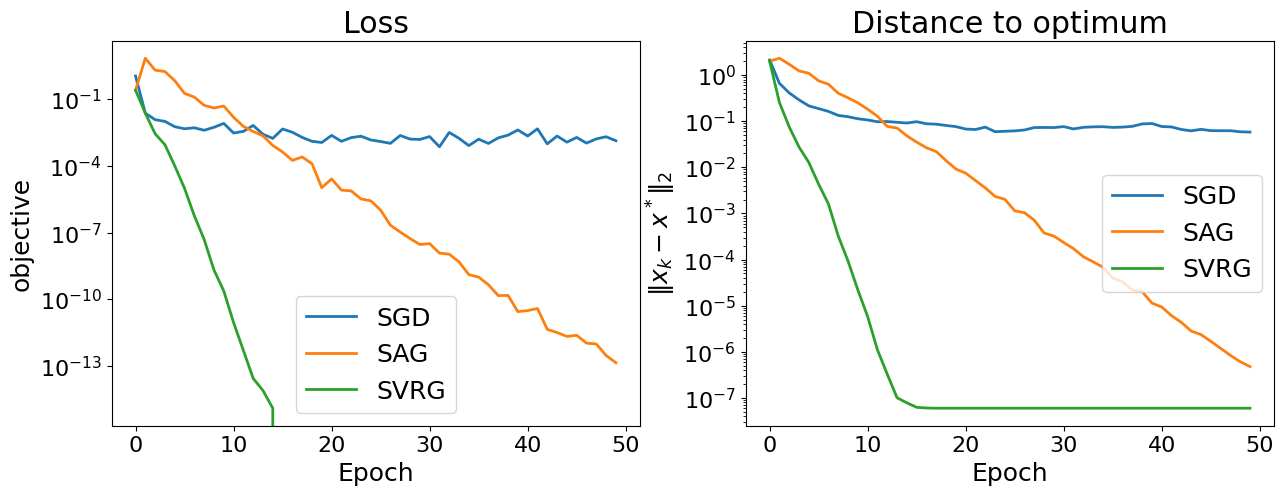

In [59]:
monitors = [monitor_sgd, monitor_sag, monitor_svrg]

solvers = ["SGD", "SAG", "SVRG"]

plot_epochs(monitors, solvers)

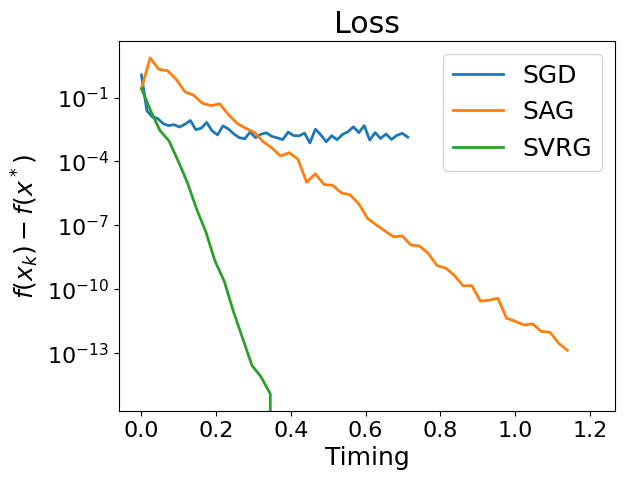

In [60]:
plot_time(monitors, solvers)

<a id='comp'></a>
## 5. Numerical comparison

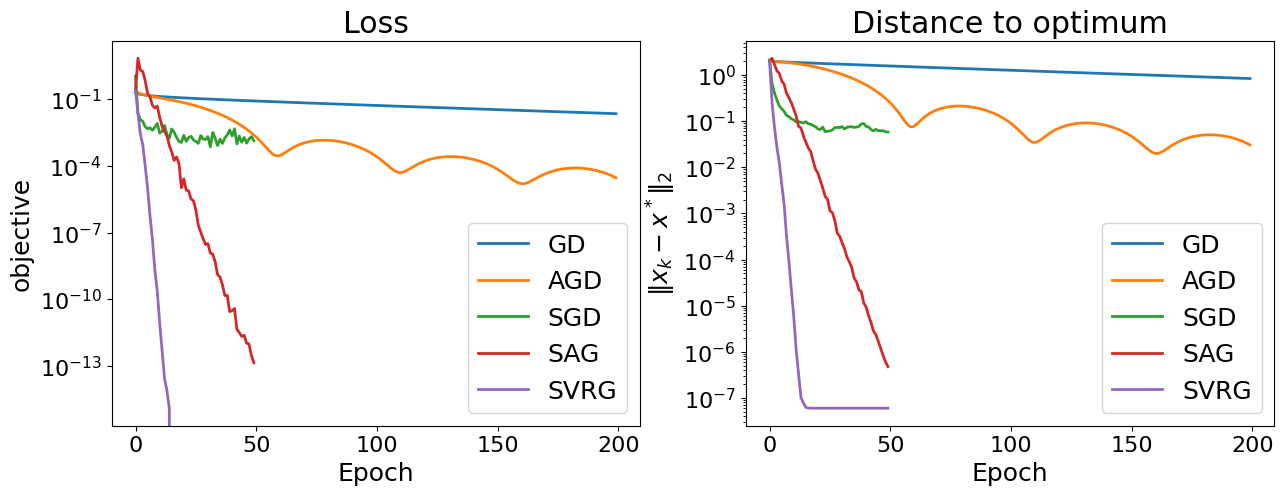

In [61]:
monitors = [monitor_gd, monitor_agd,
            monitor_sgd, monitor_sag, monitor_svrg]

solvers = ["GD", "AGD", "SGD", "SAG", "SVRG"]

plot_epochs(monitors, solvers)

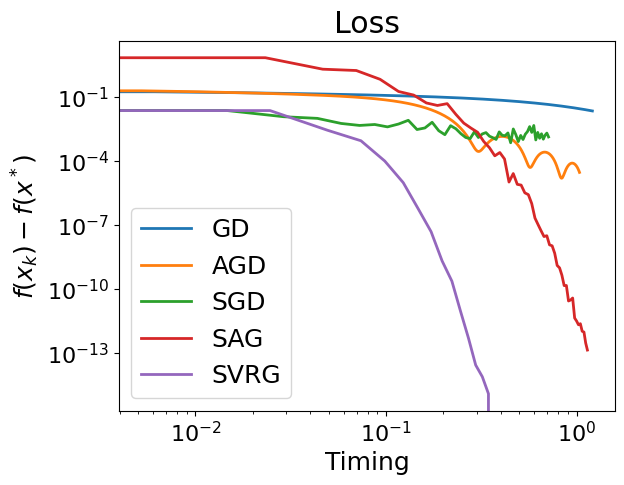

In [62]:
plot_time(monitors, solvers, xscale='log')

## Changing Value of Lambda
We will run the code above and then just run the monitors. All the results will be discussed in the last part.

lambda = 1/n

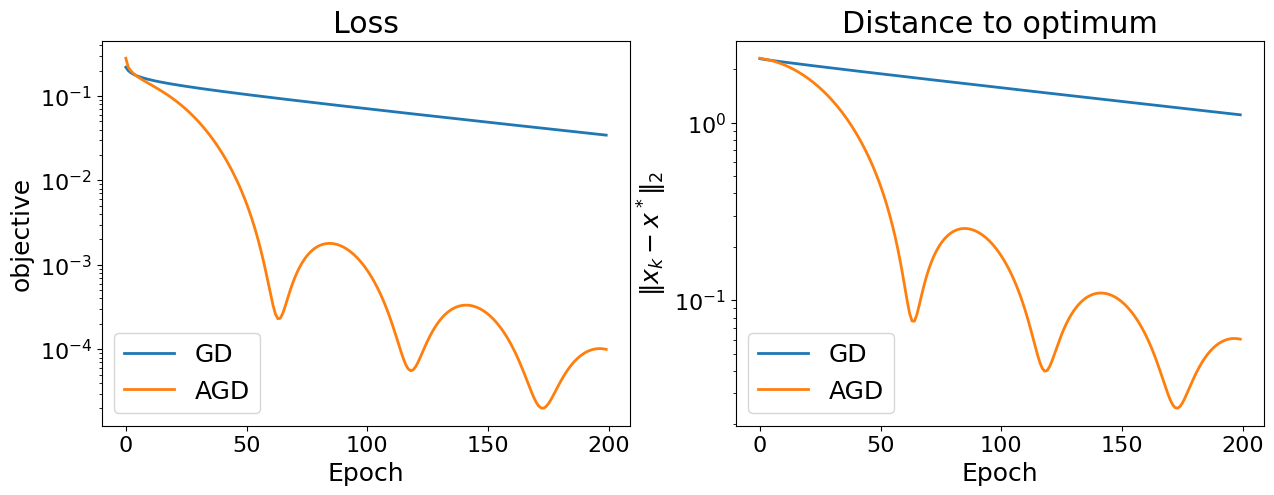

In [79]:
monitors = [monitor_gd, monitor_agd]

solvers = ["GD", "AGD"]

plot_epochs(monitors, solvers)

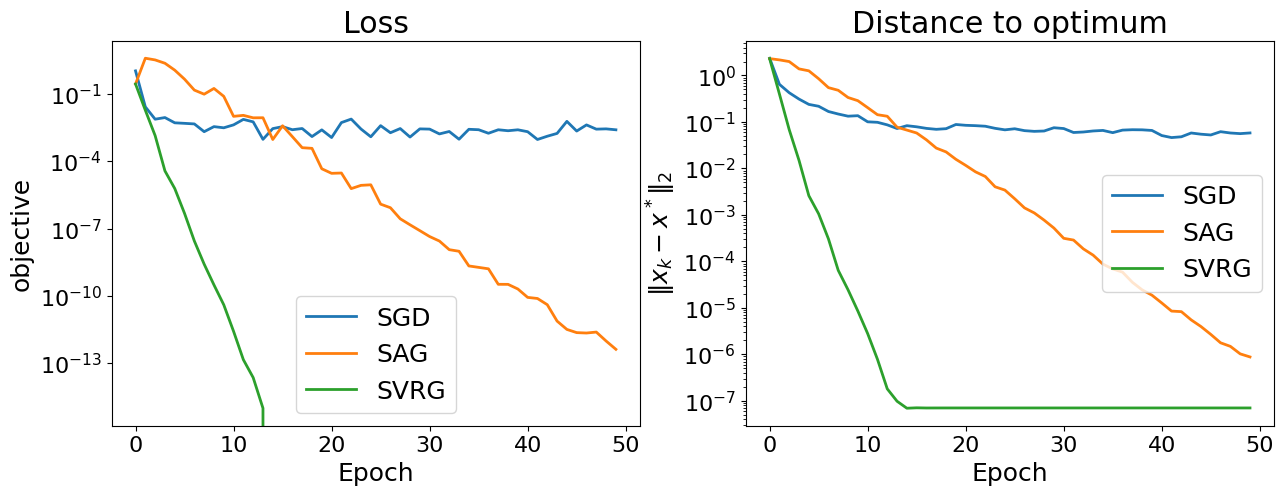

In [80]:
monitors = [monitor_sgd, monitor_sag, monitor_svrg]

solvers = ["SGD", "SAG", "SVRG"]

plot_epochs(monitors, solvers)

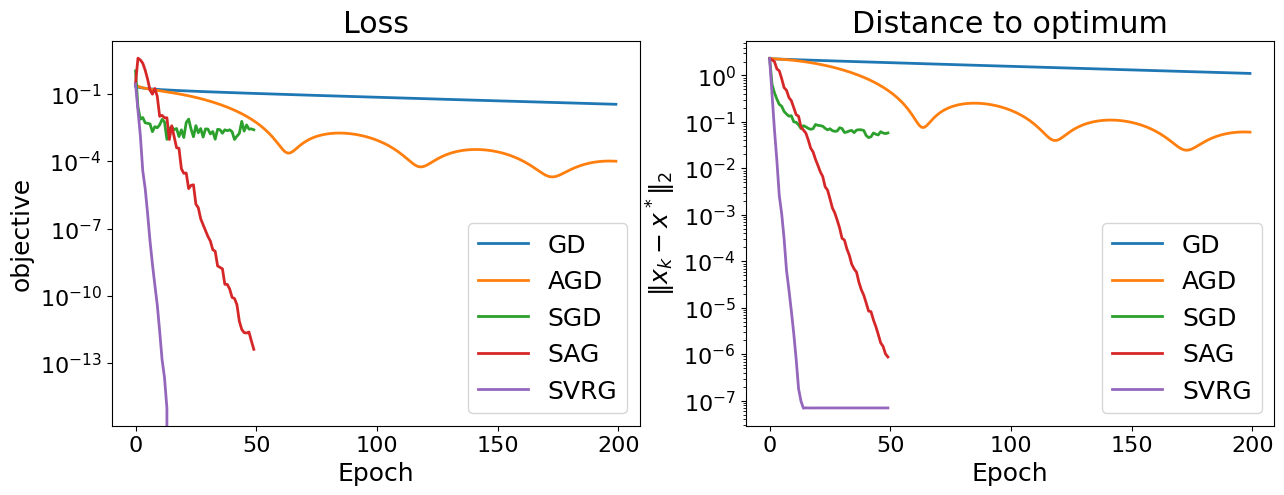

In [81]:
monitors = [monitor_gd, monitor_agd,
            monitor_sgd, monitor_sag, monitor_svrg]

solvers = ["GD", "AGD", "SGD", "SAG", "SVRG"]

plot_epochs(monitors, solvers)

lambda = 1

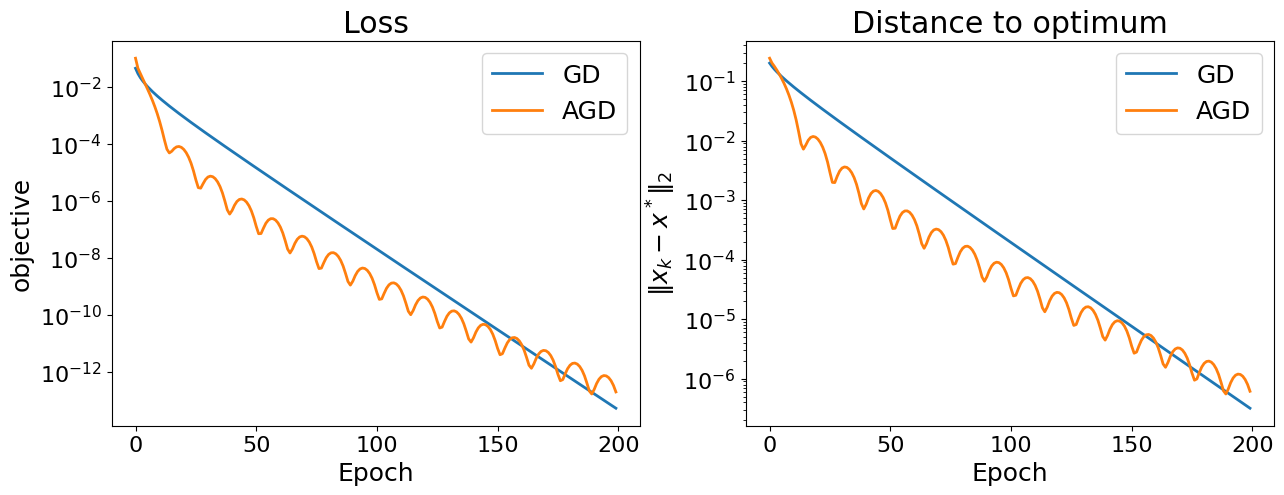

In [98]:
monitors = [monitor_gd, monitor_agd]

solvers = ["GD", "AGD"]

plot_epochs(monitors, solvers)

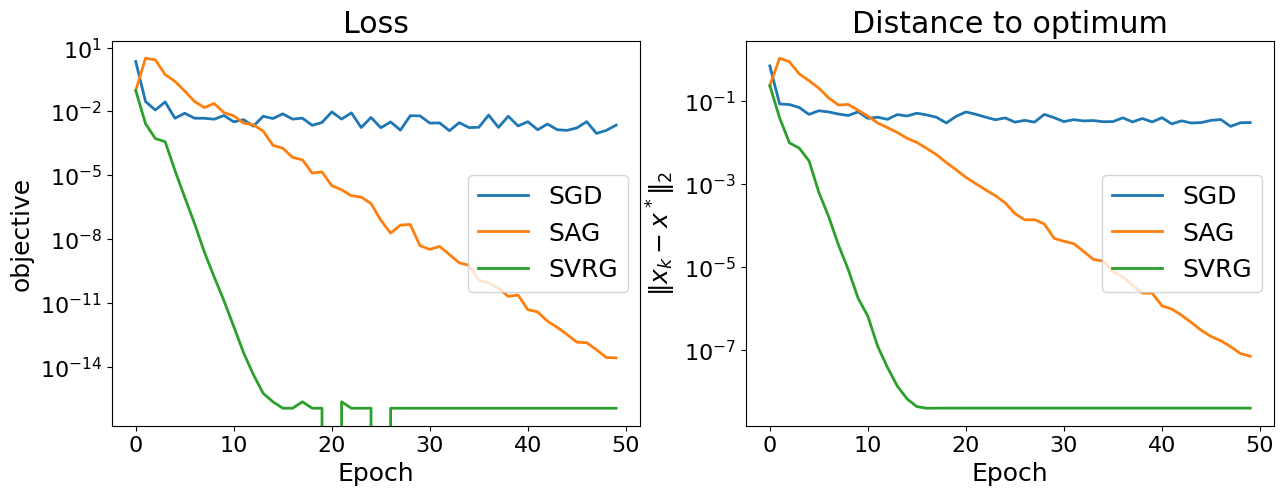

In [99]:
monitors = [monitor_sgd, monitor_sag, monitor_svrg]

solvers = ["SGD", "SAG", "SVRG"]

plot_epochs(monitors, solvers)

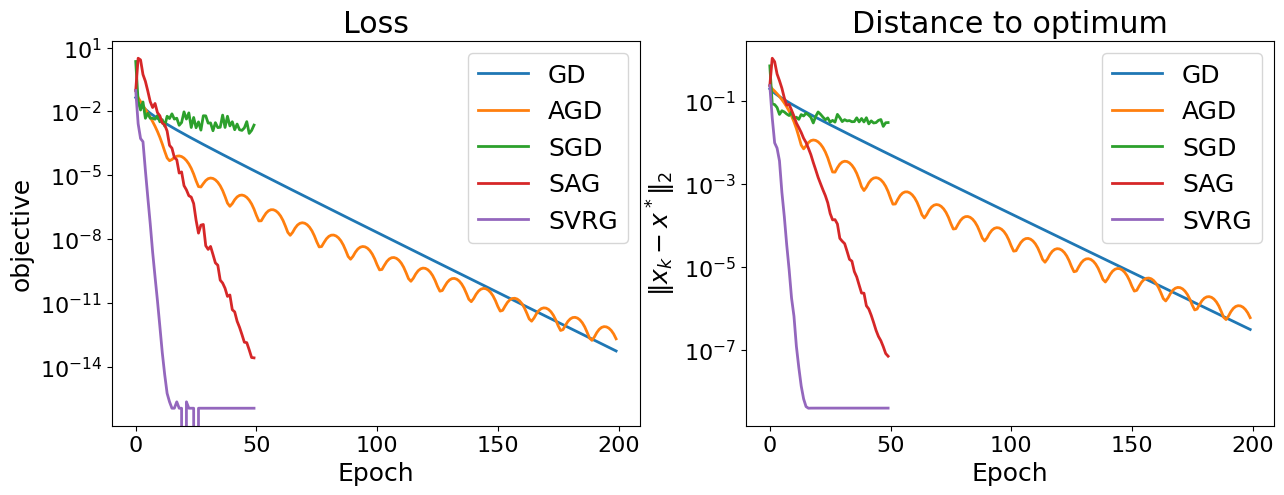

In [100]:
monitors = [monitor_gd, monitor_agd,
            monitor_sgd, monitor_sag, monitor_svrg]

solvers = ["GD", "AGD", "SGD", "SAG", "SVRG"]

plot_epochs(monitors, solvers)

Please check part 6 for the comments on the results.

## Changing the 'corr' value (with standard lambda)

corr = 0.1

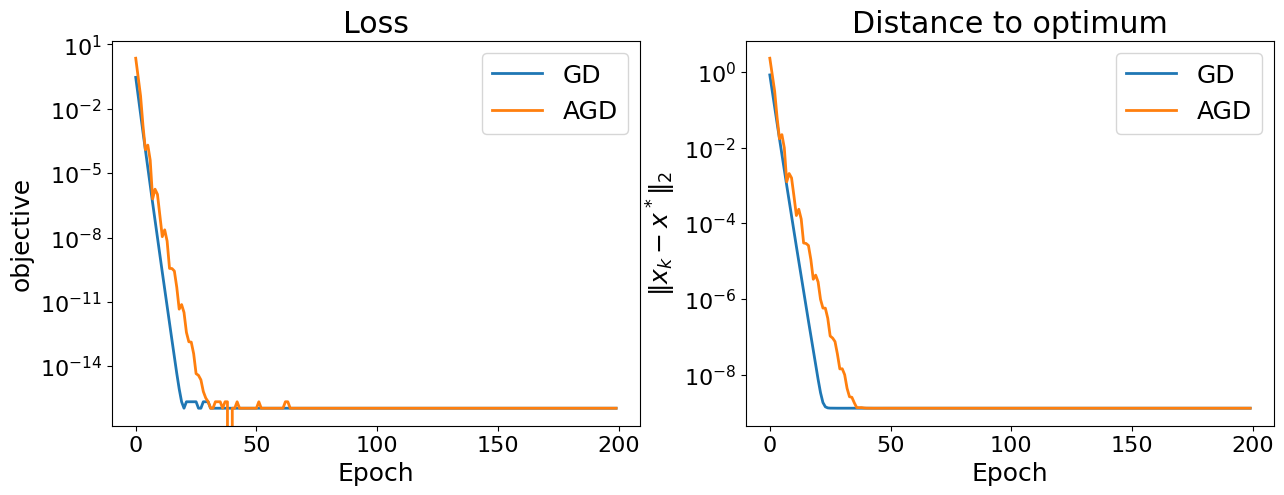

In [118]:
monitors = [monitor_gd, monitor_agd]

solvers = ["GD", "AGD"]

plot_epochs(monitors, solvers)

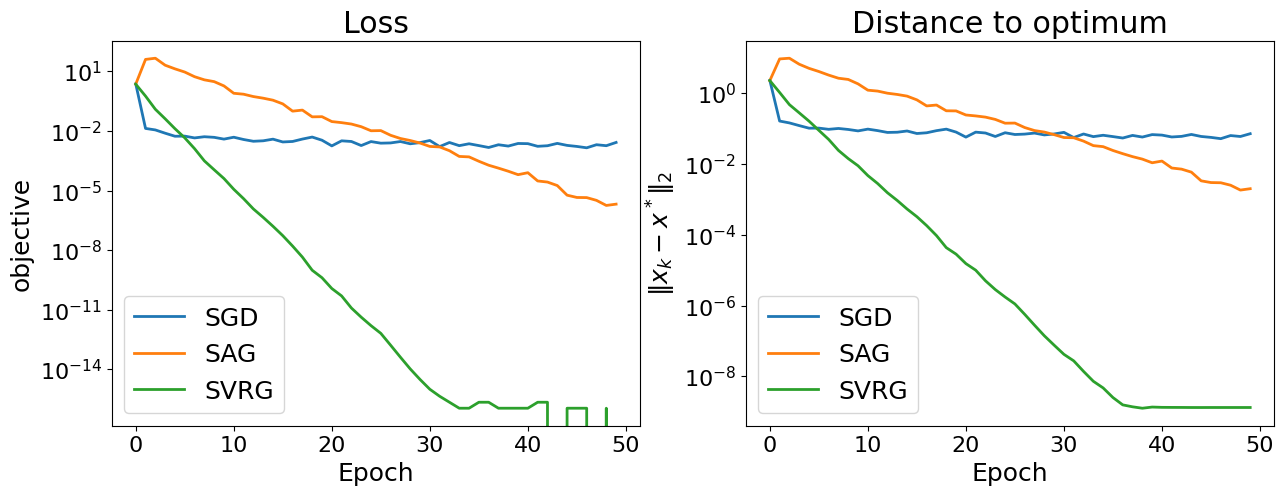

In [119]:
monitors = [monitor_sgd, monitor_sag, monitor_svrg]

solvers = ["SGD", "SAG", "SVRG"]

plot_epochs(monitors, solvers)

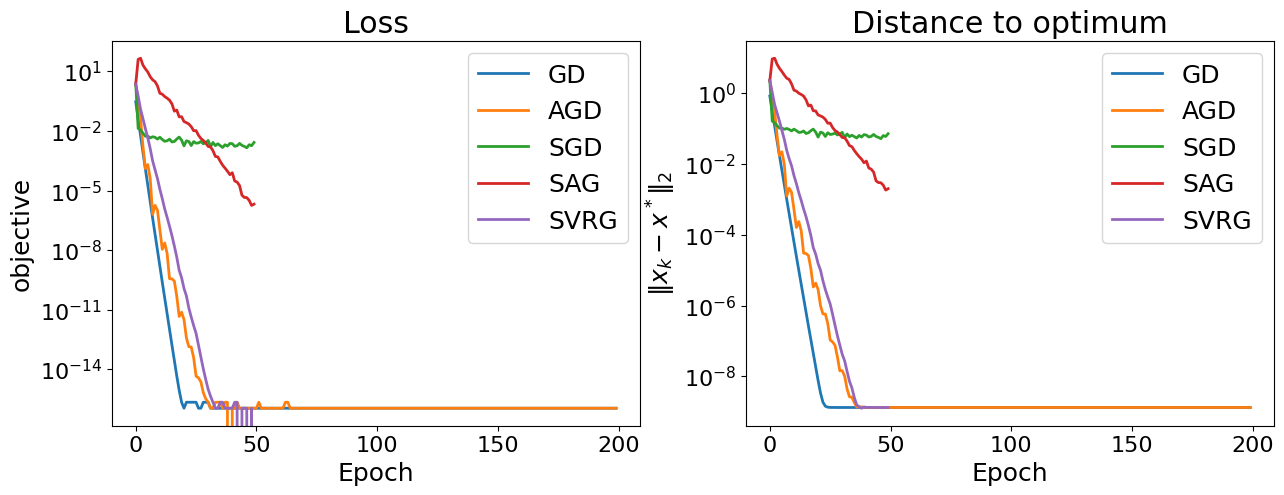

In [120]:
monitors = [monitor_gd, monitor_agd,
            monitor_sgd, monitor_sag, monitor_svrg]

solvers = ["GD", "AGD", "SGD", "SAG", "SVRG"]

plot_epochs(monitors, solvers)

corr = 0.4

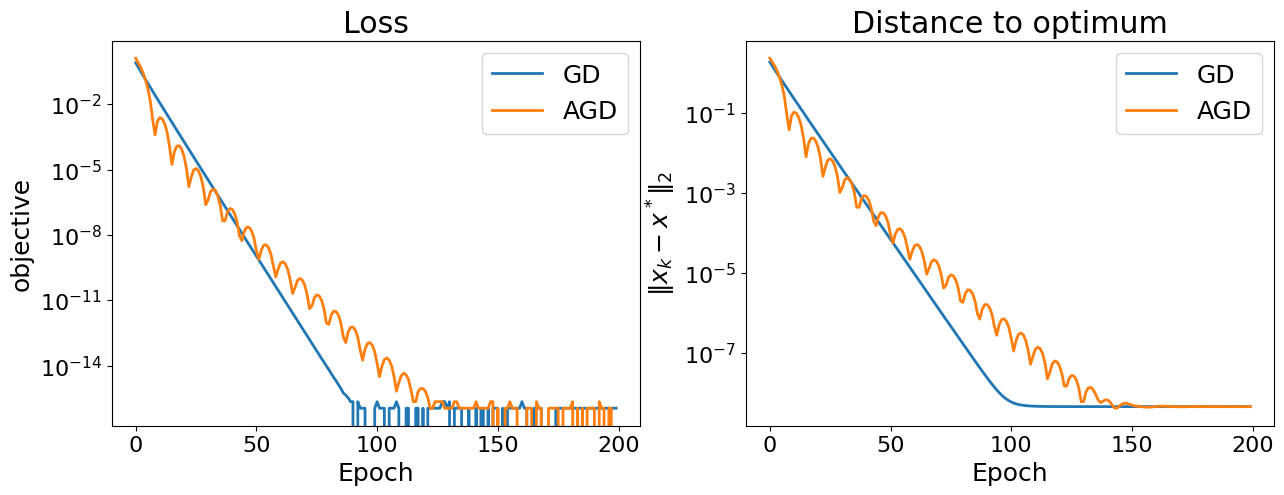

In [137]:
monitors = [monitor_gd, monitor_agd]

solvers = ["GD", "AGD"]

plot_epochs(monitors, solvers)

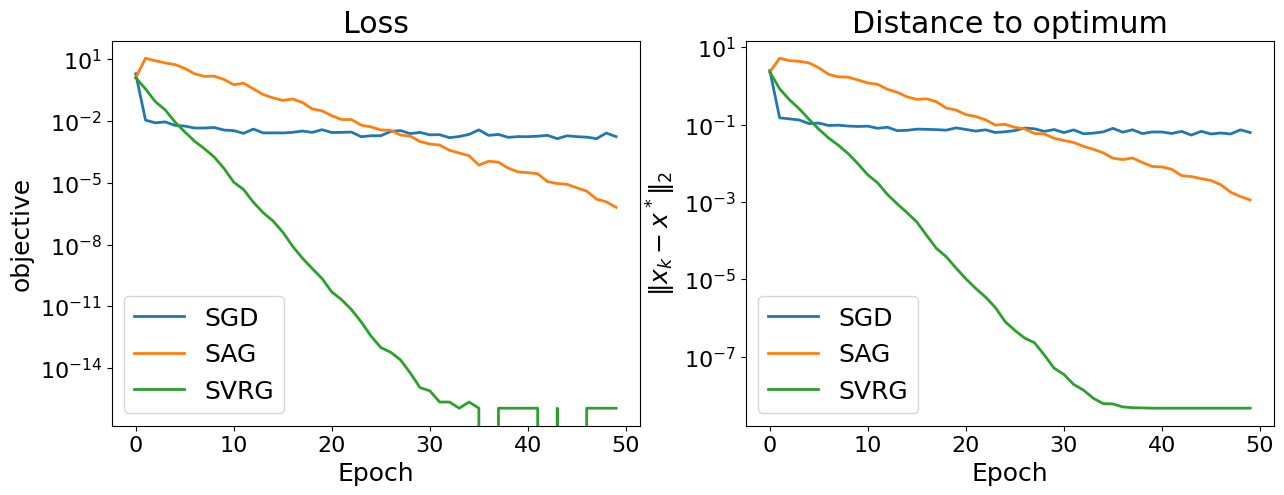

In [138]:
monitors = [monitor_sgd, monitor_sag, monitor_svrg]

solvers = ["SGD", "SAG", "SVRG"]

plot_epochs(monitors, solvers)

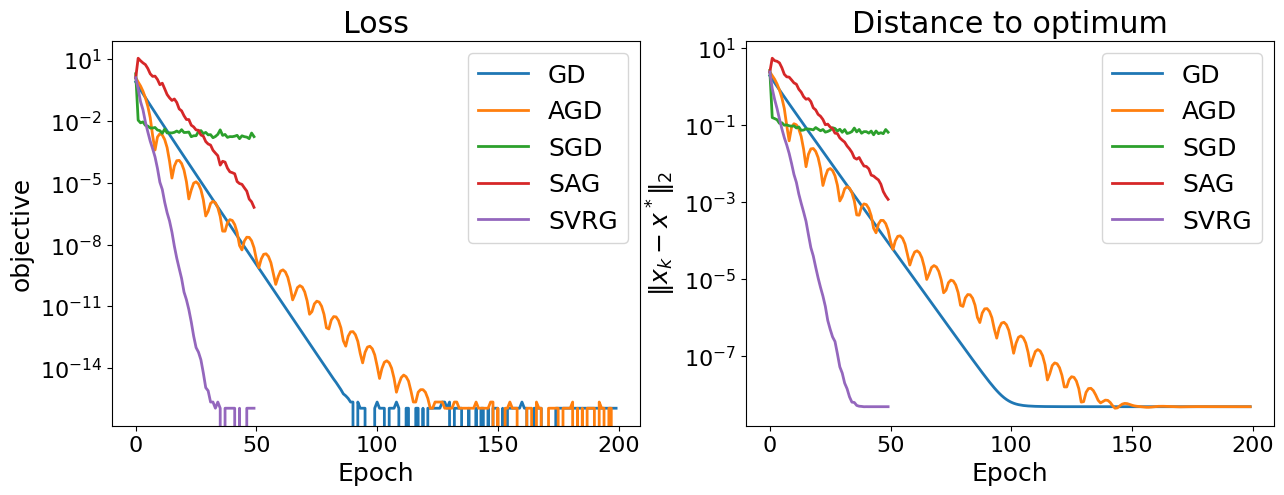

In [139]:
monitors = [monitor_gd, monitor_agd,
            monitor_sgd, monitor_sag, monitor_svrg]

solvers = ["GD", "AGD", "SGD", "SAG", "SVRG"]

plot_epochs(monitors, solvers)

<a id='conc'></a>
## 6. Conclusion

*QUESTIONS*:
- Compare and comment your results

1- Gradient Descent is the 'smoother' one but clearly needs much more time to decrease the loss compared to other methods. In terms of performance it is the worst as it is still very far from the optimum after the iterations specified and the loss was still very high.

2- Accelerated Gradient Descent is much better, it is smooth up until it gets closer to the optimum: at this point we observe oscillations in the loss decrease and distance to optimality. This is due as we said to the fact that it observes where it's going by using some momentum strategy, and when we observe for instance a sign change it'll start to oscillate.

3- Stochastic Gradient Descent suffers a lot from oscillations as the gradient used is very noisy, since it depends on only one sample. The loss decrease is a bit better than standard GD, similar to AGD but the distance to optimality is better than both and faster. This is due to the fact that one sample/ gradient computation generalizes better at the cost of unstable trajectory and oscillations. Variants of SGD could help prevent this behavior.

4- Stochastic Average Gradient (SAG)is much better than the 3 previous methods: we observe less oscillations than SGD but a much better and faster decrease of loss and distance to optimum. This is due to the fact that SAG computes at the beginning the full gradient (with all samples), then at each training iteration, it computes one gradient, updates the corresponding coordinate in the full gradient, and then takes the average of these gradients like standard GD. By doing this, we still benefit from one gradient computation/ iteration (except for first step), but also benefit by looking at previous gradients or samples to incorporate more information about where to go. The solution reached is much better than the 3 previous methods.

5- Stochastic Variance Reduced Gradient (SVRG) is the best method: It uses the covariate function to decrease the variance of the evaluated gradients to reduce oscillations and noise and still benefits from one gradient computation/ iteration. In terms of loss decrease and distance to optimum, it is much faster than SAG as it reaches optimality faster and even the results are a bit better. It is by far the best numerical method so far.


- Change the value of the ridge regularization (the ``lbda`` parameter) to low ridge $\lambda = 1 / n$ and high ridge regularization $\lambda = 1$ and compare your results. Comment.

Analysis:
Low Regularization: GD and AGD don't reach the same point because they have a slightly higher loss and distance to optimum, which means that they will need more iterations. SGD loss and distance to optimum's decrease are also a bit slower than before (the decrease at the beginning). SAG and SVRG didn't really change, they became a bit better (they reached a point where the loss and distance to optimum were slightly better than before).

High Regularization: GD became very powerful and its loss and distance to optimum are very low after the iterations. It doesn't suffer from oscillations. AGD has also a similar performance than GD but suffers from more oscillations.

SGD and SAG results didn't change a lot (the first a little bit slower, the second very similar to standard regularization). SVRG became faster but we can see that when it reached the optimal solution it started oscillating.
GD and AGD results were better than SGD and SAG, but SVRG was still the best method.



- Play also with the level of correlation between features (parameter ``corr`` above), and compare results with low and high correlation.

Here we will keep the standard lambda and change the corr parameter.

Correlation = 0.9: This was the base value and the convergence behavior of optimizers is explained above. Here the problem is ill-conditioned due to the high correlation between our features. Stochastic methods however performed well but deterministic methods required a high regularization to do well (to recover a full rank matrix).

Correlation = 0.1: Here our features are not correlated anymore. As a result, we can see a much faster convergence for deterministic methods (GD and AGD) with a standard regularization value. GD is smoother than AGD but at the end (near optimality) we observe some fluctuations. SGD and SAG performances didn't change much (less oscillations) mainly because we're evaluating the gradient on one sample. Here the correlation doesn't play an important role.
SVRG however became slower (even slower than GD and AGD). An explanation for this would be the higher variance across features and gradients when corr is low. This means it takes more time for SVRG to perform variance reduction and therefore it takes more time to reach optimality.

Correlation = 0.4: GD and AGD are converging faster than corr =0.9 but slower than corr= 0.1. SGD and SAG didn't change that much. SVRG is faster than corr= 0.1 but slower than corr =0.9. This has the same explanation as before.



- Conclude

We can conclude that:
- Gradient Descent is very smooth but takes more time to each the solution.
- Accelerated Gradient Descent reaches optimality faster but suffers from oscillations.
- Stochastic Methods are faster and can reach better solution than deterministic methods but suffers a lot from oscillations due to the noisy gradients. Variance Reduction techniques let SGD be smoother and reaches the best point.

Regularization Effect:
- A high regularization makes deterministic methods converge faster especially when dealing with multi-collinearity. A lower regularization term would do the opposite.
- Regularization might slow down some stochastic methods, but SVRG was a little bit faster.

Correlation across features:
- When features are independent (low correlation), deterministic methods outperform stochastic methods. This is due to the fact that we are not dealing with ill conditioned problems.
- SGD and SAG were not that affected by the correlation mainly because they rely on single samples.
- SVRG however becomes slower due to the higher variance across features, making the role of variance reduction significantly important and therefore taking more time to converge.


